In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-sales/Walmart_sales.csv


The data contains the following columns:

Store: Store number

Date: Sales week start date

Weekly_Sales: Sales

Holiday_Flag: Mark on the presence or absence of a holiday

Temperature: Air temperature in the region

Fuel_Price: Fuel cost in the region

CPI: Consumer price index

Unemployment: Unemployment rate

In [2]:
import matplotlib.pyplot as plt
import seaborn as ss
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from lightgbm import LGBMRegressor

In [3]:
# Reading the data from csv file
walmart=pd.read_csv("/kaggle/input/walmart-sales/Walmart_sales.csv")

In [4]:
# Fetching information about data like datatypes,checking null values ,column names and no of rows and columns
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


*****There is no missing values present in the data and only Date is in object data type.*****

In [5]:
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [6]:
#copied the original data to walmart_cp
walmart_cp=walmart.copy()

In [7]:
std=StandardScaler()
col = walmart_cp.drop("Date",axis=1).columns
for i in col:
    walmart_cp[i]=std.fit_transform(walmart_cp[[i]])

In [8]:
walmart_cp

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,-1.693979,05-02-2010,1.057420,-0.274204,-0.995136,-1.713800,1.004175,0.056964
1,-1.693979,12-02-2010,1.054348,3.646917,-1.201170,-1.766089,1.007880,0.056964
2,-1.693979,19-02-2010,1.001206,-0.274204,-1.124178,-1.840166,1.009074,0.056964
3,-1.693979,26-02-2010,0.642828,-0.274204,-0.760907,-1.737766,1.009849,0.056964
4,-1.693979,05-03-2010,0.899914,-0.274204,-0.767955,-1.598328,1.010624,0.056964
...,...,...,...,...,...,...,...,...
6430,1.693979,28-09-2012,-0.591489,-0.274204,0.228602,1.390883,0.519270,0.365109
6431,1.693979,05-10-2012,-0.555551,-0.274204,0.229144,1.364738,0.523256,0.356046
6432,1.693979,12-10-2012,-0.553762,-0.274204,-0.335825,1.397419,0.527241,0.356046
6433,1.693979,19-10-2012,-0.582715,-0.274204,-0.227385,1.329879,0.527332,0.356046


In [9]:
#Date is in object type converting it to date time format and extracting year and month
walmart_cp["Date"]=pd.to_datetime(walmart_cp["Date"], dayfirst=True)
walmart_cp["Date"]=walmart_cp["Date"].dt.strftime('%Y-%m')

In [10]:
walmart_cp

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,-1.693979,2010-02,1.057420,-0.274204,-0.995136,-1.713800,1.004175,0.056964
1,-1.693979,2010-02,1.054348,3.646917,-1.201170,-1.766089,1.007880,0.056964
2,-1.693979,2010-02,1.001206,-0.274204,-1.124178,-1.840166,1.009074,0.056964
3,-1.693979,2010-02,0.642828,-0.274204,-0.760907,-1.737766,1.009849,0.056964
4,-1.693979,2010-03,0.899914,-0.274204,-0.767955,-1.598328,1.010624,0.056964
...,...,...,...,...,...,...,...,...
6430,1.693979,2012-09,-0.591489,-0.274204,0.228602,1.390883,0.519270,0.365109
6431,1.693979,2012-10,-0.555551,-0.274204,0.229144,1.364738,0.523256,0.356046
6432,1.693979,2012-10,-0.553762,-0.274204,-0.335825,1.397419,0.527241,0.356046
6433,1.693979,2012-10,-0.582715,-0.274204,-0.227385,1.329879,0.527332,0.356046


In [11]:
walmart_cp["Date"]=pd.to_datetime(walmart_cp["Date"])

In [12]:
walmart_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   float64       
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   float64       
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 402.3 KB


In [13]:
#Sorting data by date and group by date to view data in line graph
walmart_cp=walmart_cp.sort_values("Date")
walmartcopy=walmart_cp.groupby("Date").mean()

In [14]:
walmartcopy

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-01,-1.233581e-18,0.018501,0.706076,-1.321646,-1.452426,-0.095136,0.330622
2010-03-01,-2.467162e-18,-0.064324,-0.274204,-0.730306,-1.246016,-0.092686,0.330622
2010-04-01,1.973730e-18,-0.032721,-0.274204,-0.203996,-1.067726,-0.099100,0.265794
2010-05-01,-9.251859e-19,-0.017157,-0.274204,0.254865,-0.961377,-0.100032,0.265794
2010-06-01,3.700743e-18,0.037336,-0.274204,0.781455,-1.243183,-0.090810,0.265794
2010-07-01,9.868649e-19,-0.023525,-0.274204,1.013025,-1.273707,-0.090888,0.228937
2010-08-01,1.233581e-18,-0.008009,-0.274204,0.989831,-1.254089,-0.085545,0.228937
2010-09-01,-3.238150e-18,-0.110120,0.706076,0.658094,-1.359721,-0.084449,0.228937
2010-10-01,-1.973730e-18,-0.144955,-0.274204,0.081228,-1.201190,-0.079401,0.253840


# Comparing Weekly sales and temperature

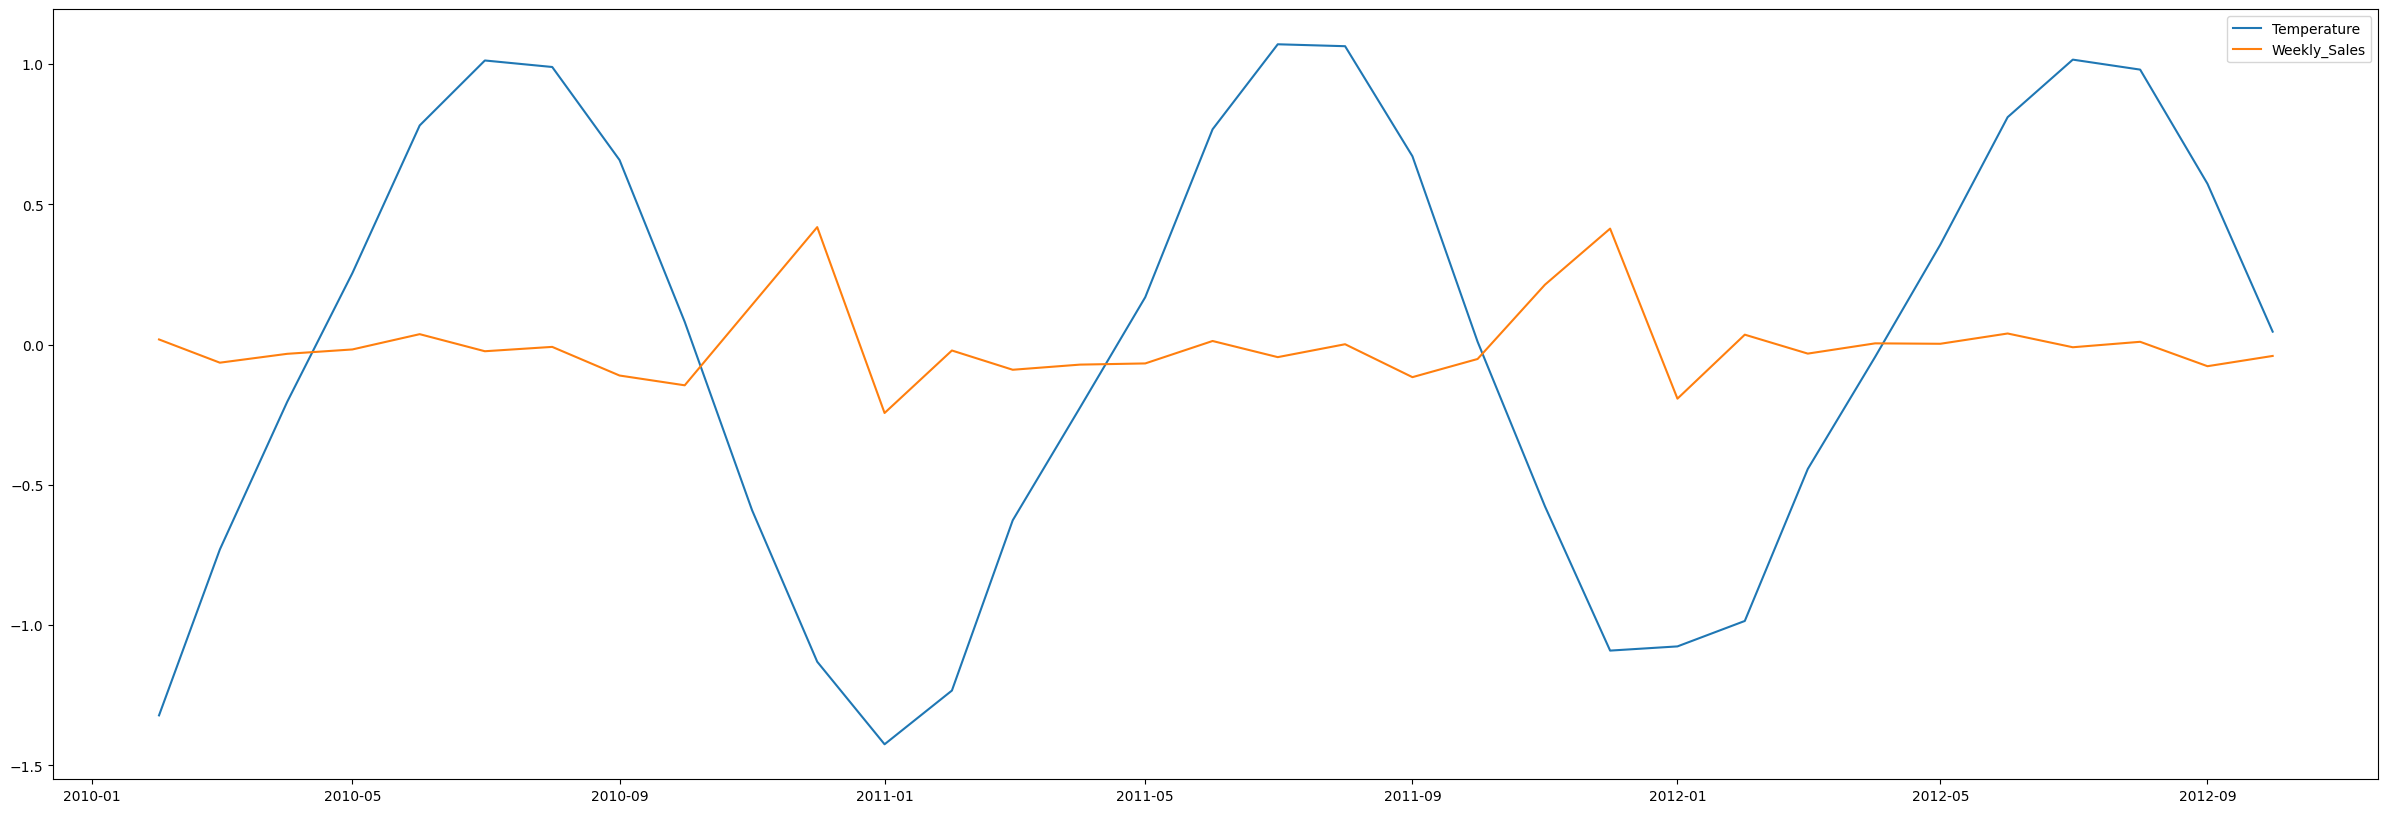

In [15]:
plt.figure(figsize=(30,10))
plt.plot(walmartcopy.index,walmartcopy["Temperature"],label="Temperature")
plt.plot(walmartcopy["Weekly_Sales"],label="Weekly_Sales")
plt.legend()

1. From the line graph sales are increasing from september month to december. Where as from december to january there is sudden drop this pattern occurring in 2010 and 2011 same.

2. In other months sales seems to be average through out the year no sudden hike or drop found.

# Comparing Weekly sales and Fuel price

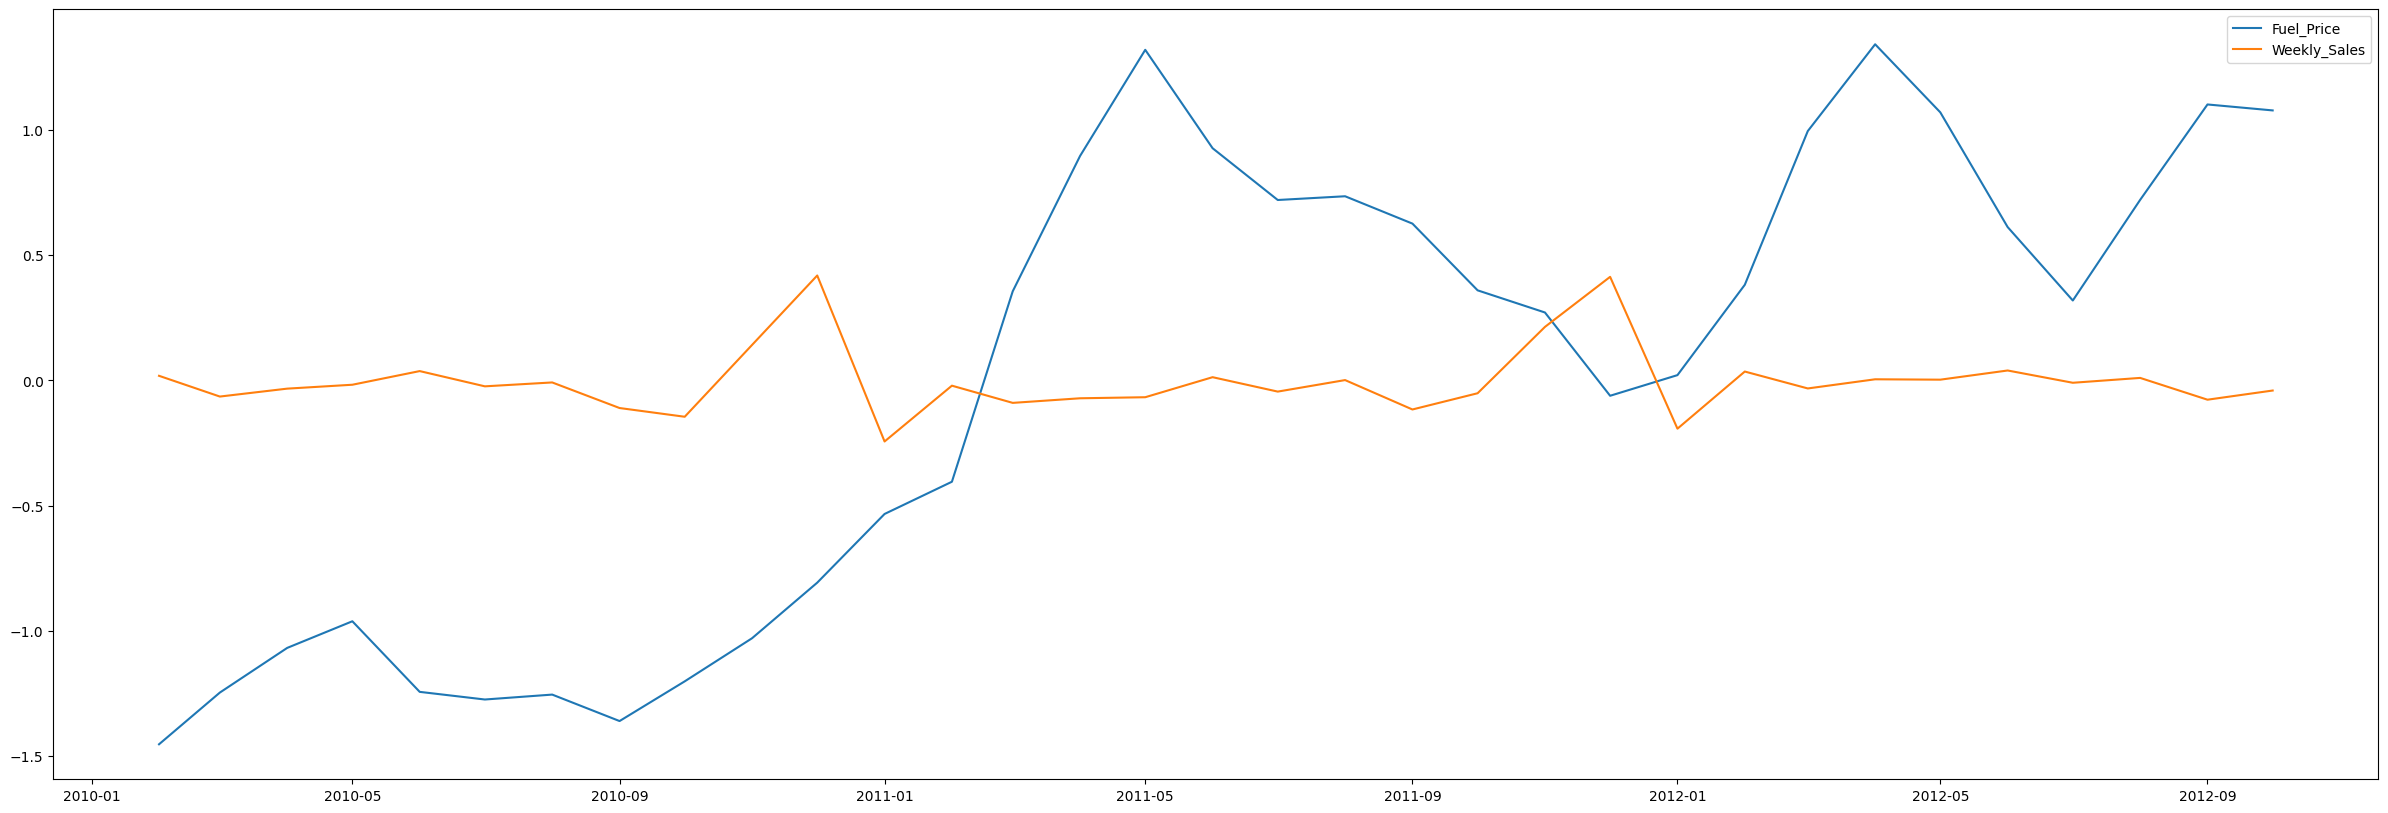

In [16]:
plt.figure(figsize=(30,10))
plt.plot(walmartcopy.index,walmartcopy["Fuel_Price"],label="Fuel_Price")
plt.plot(walmartcopy["Weekly_Sales"],label="Weekly_Sales")
plt.legend()

# Comparing Weekly sales and Unemployment

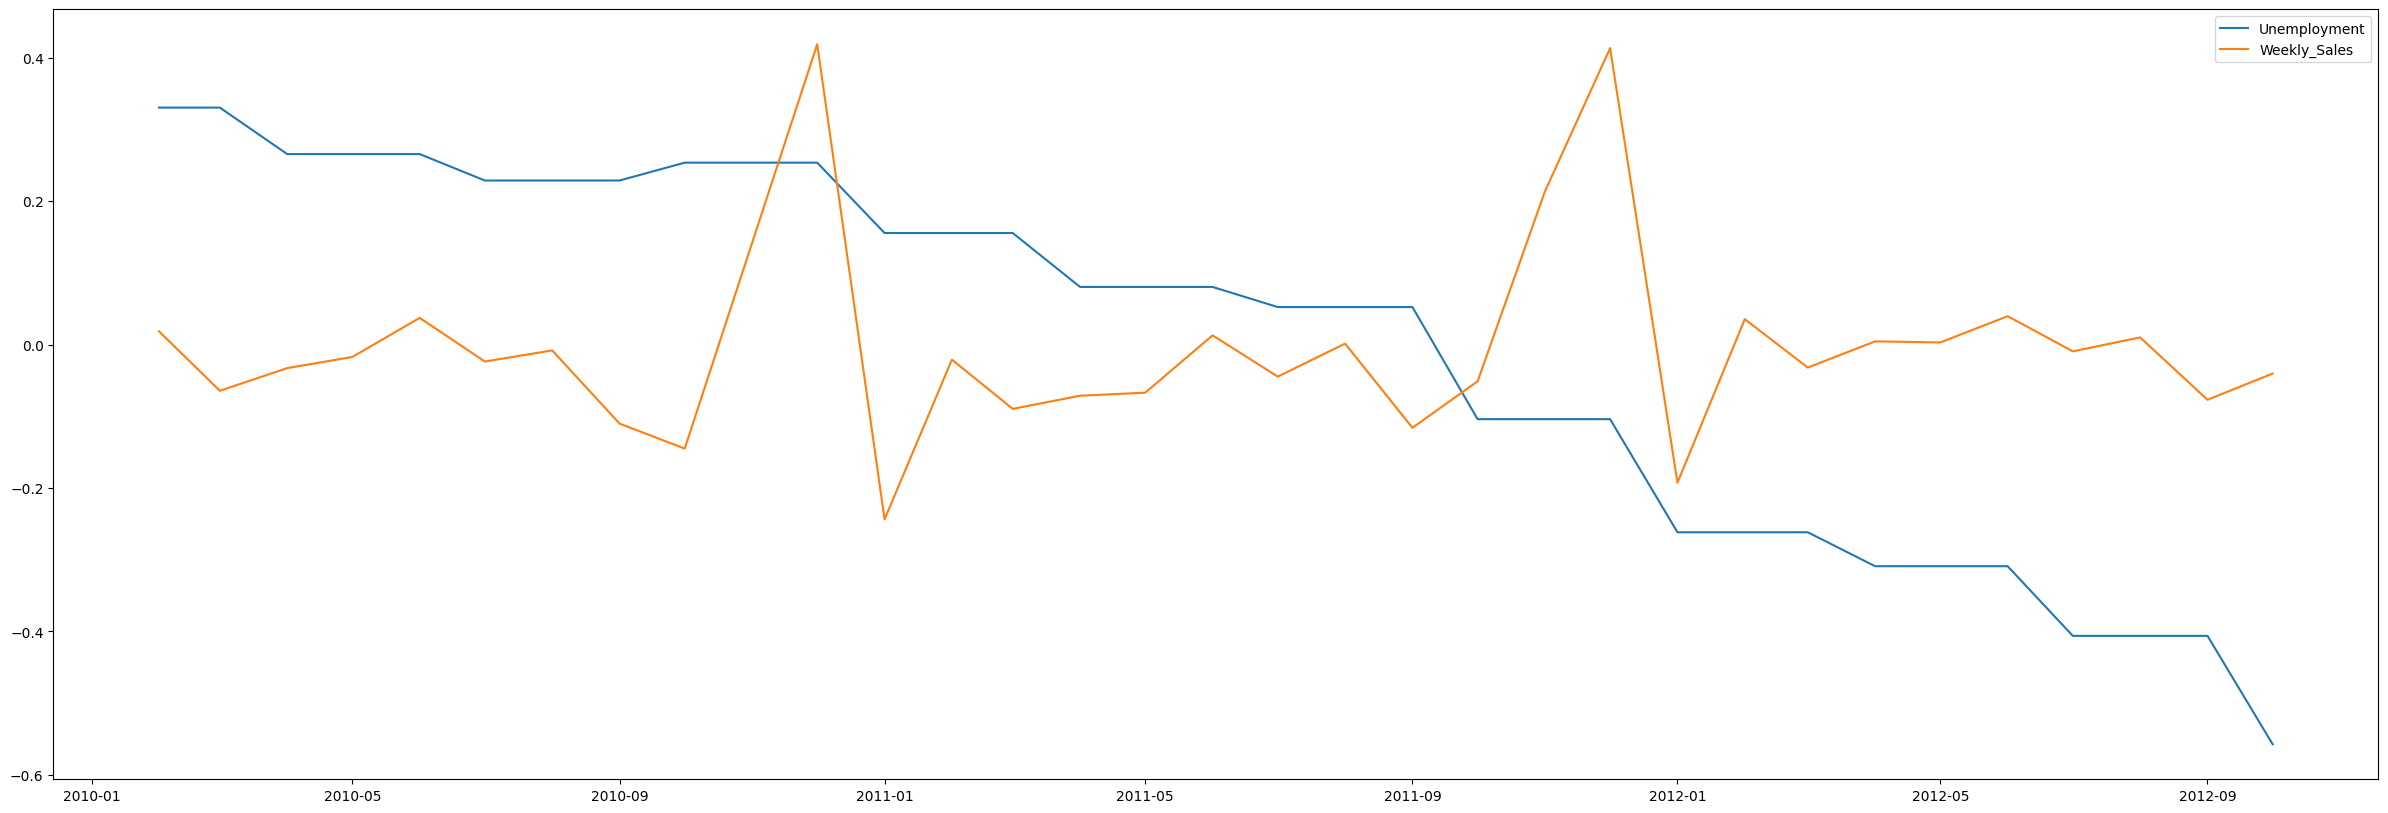

In [17]:
plt.figure(figsize=(30,10))
plt.plot(walmartcopy.index,walmartcopy["Unemployment"],label="Unemployment")
plt.plot(walmartcopy["Weekly_Sales"],label="Weekly_Sales")
plt.legend()

# Comparing Weekly sales and CPI

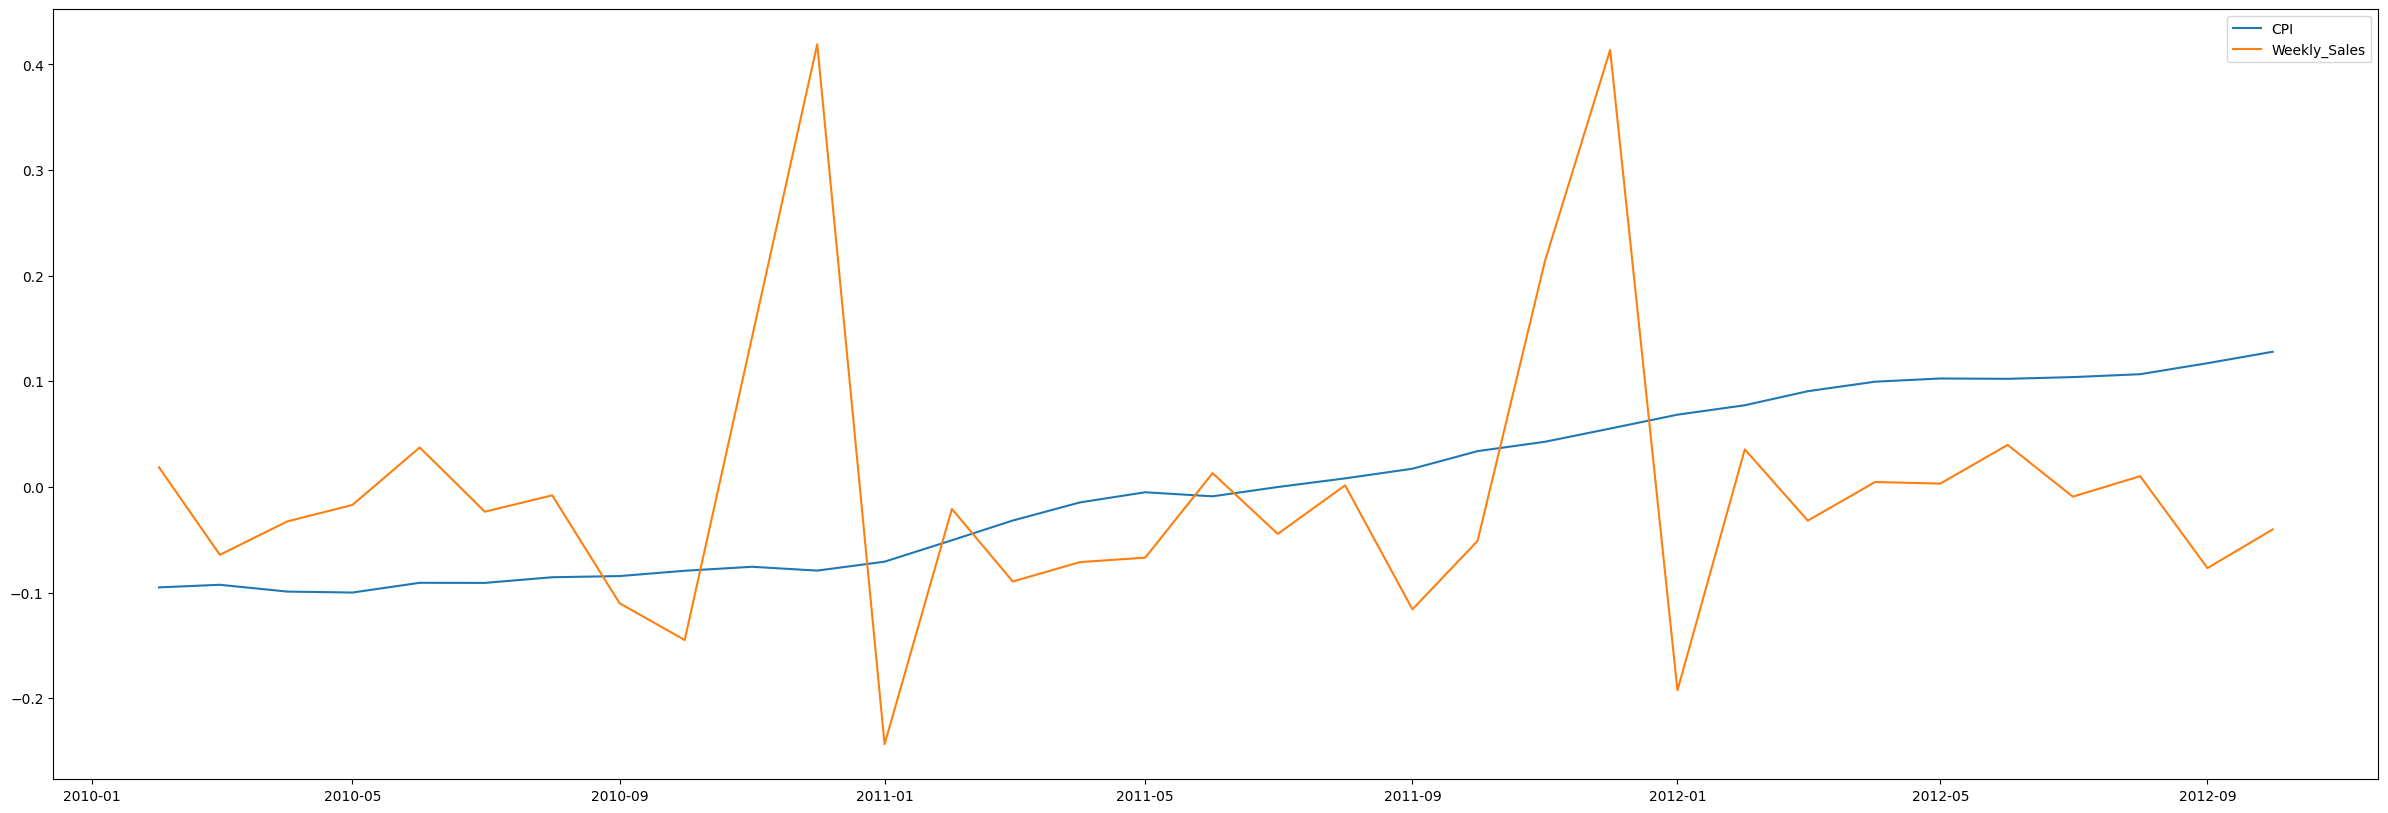

In [18]:
plt.figure(figsize=(30,10))
plt.plot(walmartcopy.index,walmartcopy["CPI"],label="CPI")
plt.plot(walmartcopy["Weekly_Sales"],label="Weekly_Sales")
plt.legend()

# Comparing Weekly sales and Holiday_Flag

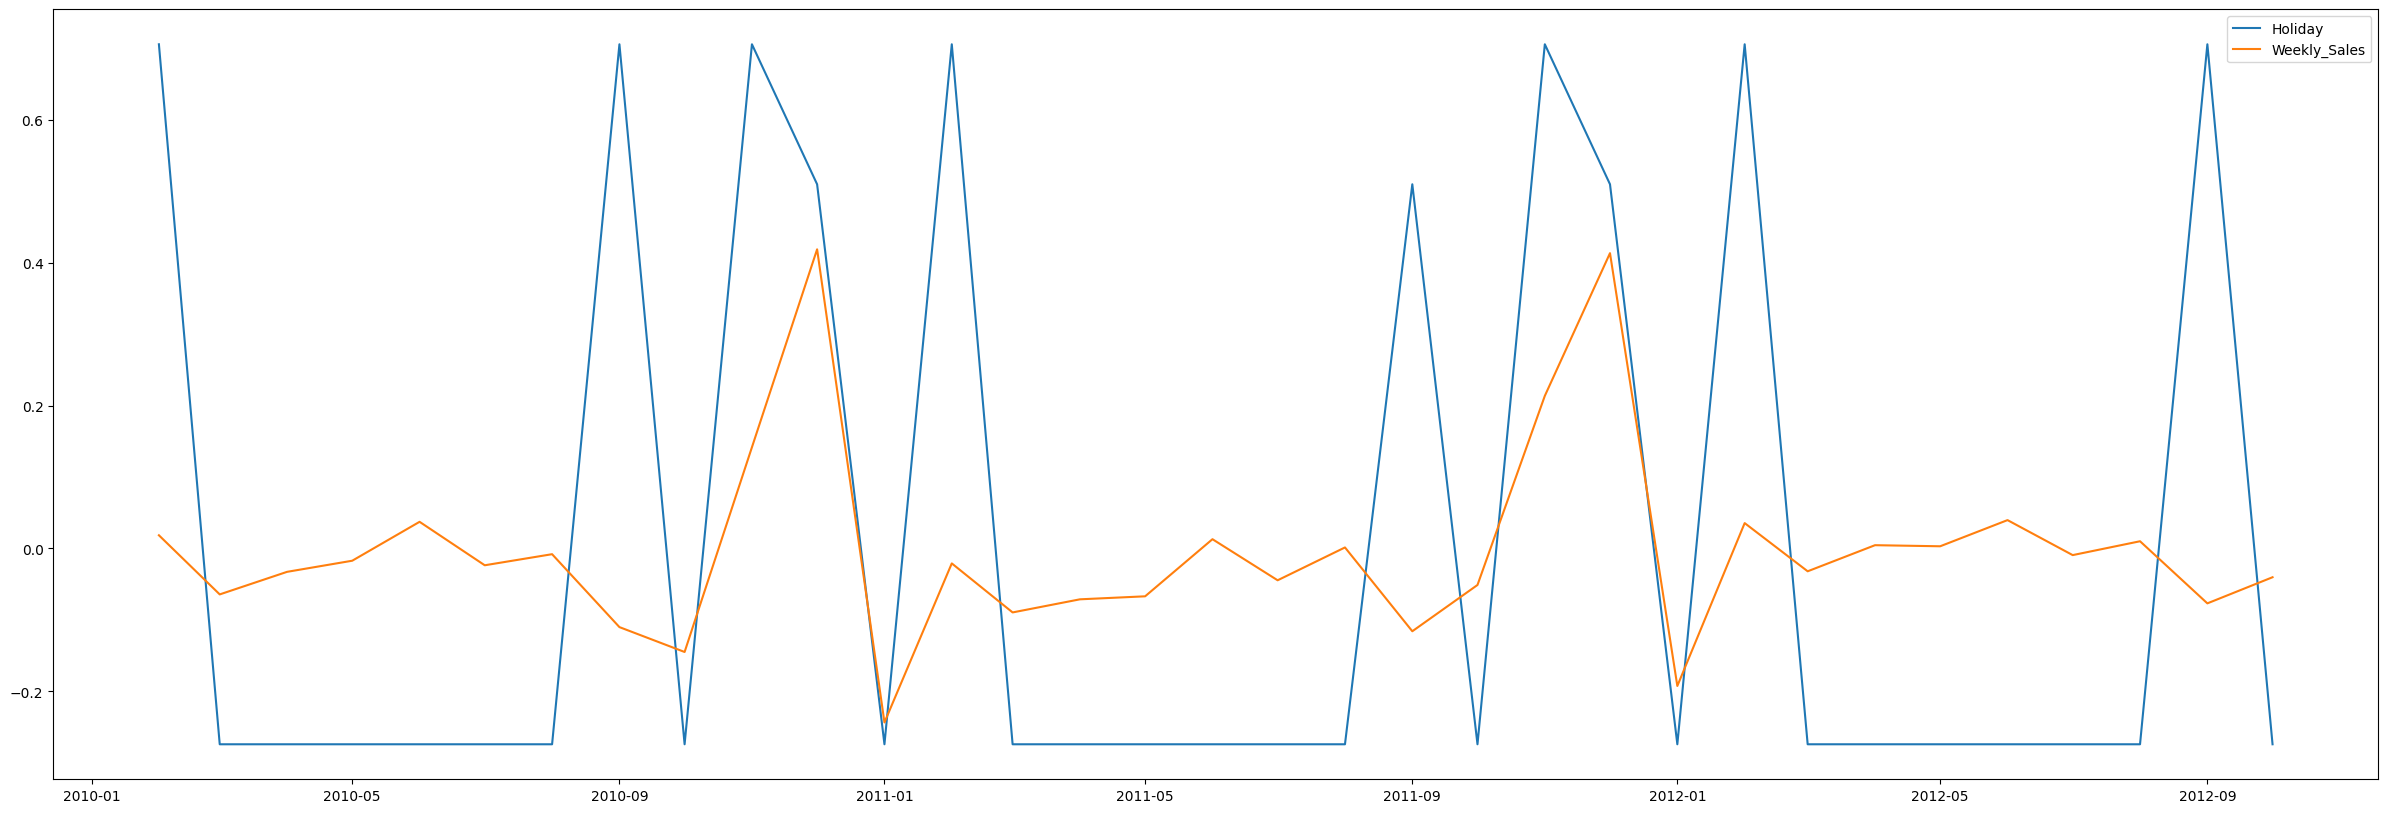

In [19]:
plt.figure(figsize=(30,10))
plt.plot(walmartcopy.index,walmartcopy["Holiday_Flag"],label="Holiday")
plt.plot(walmartcopy["Weekly_Sales"],label="Weekly_Sales")
plt.legend()

<Axes: >

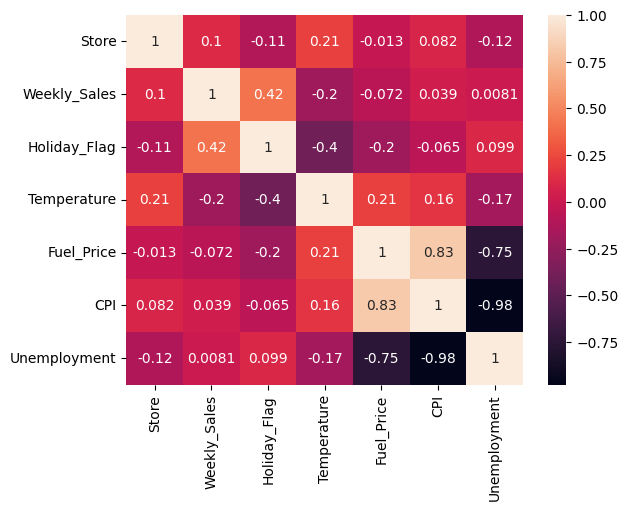

In [20]:
# checking correlation between dependent variable.
cor=walmartcopy.corr()
ss.heatmap(cor,annot=True)

Unemployment and CPI is highly negative correlating.

Text(0, 0.5, 'CPI')

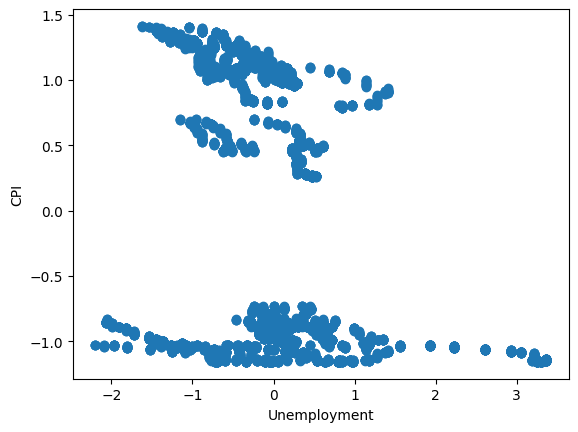

In [21]:
plt.scatter(walmart_cp["Unemployment"],walmart_cp["CPI"])
plt.xlabel("Unemployment")
plt.ylabel("CPI")

In [22]:
x=walmart_cp.drop(["Date","Weekly_Sales"],axis=1)
y=walmart_cp["Weekly_Sales"]

In [23]:
xtrain, xtest, ytrain, ytest=train_test_split(x,y,test_size=0.3)

In [24]:
xtrain

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
3635,0.230997,-0.274204,-2.042659,0.608721,-0.953155,-0.096576
5379,1.154986,-0.274204,0.360356,0.972568,-1.062360,2.607425
3503,0.153998,-0.274204,0.158116,1.053181,0.928711,-0.379664
2623,-0.307996,-0.274204,-2.113687,0.018286,-0.981544,-0.121633
6365,1.693979,-0.274204,0.725254,0.848381,0.364225,0.333655
...,...,...,...,...,...,...
3990,0.384995,-0.274204,1.778741,0.894134,-1.038247,1.560371
2790,-0.230997,-0.274204,0.487772,0.848381,0.933998,-0.386595
691,-1.385983,-0.274204,0.530605,0.591291,1.289640,-1.171885
5100,1.000988,-0.274204,-0.384622,-0.423995,1.164937,-0.150954


In [25]:
ytrain

3635   -0.350390
5379   -1.145681
3503   -0.584048
2623    0.237877
6365   -0.452701
          ...   
3990    0.156064
2790    1.783023
691    -1.259519
5100   -1.335431
6385   -0.484406
Name: Weekly_Sales, Length: 4504, dtype: float64

In [26]:
xtest

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
2239,-0.538993,3.646917,-1.587214,0.142474,0.614733,-0.942109
5058,1.000988,3.646917,-1.057488,-0.761697,1.019476,0.211036
6214,1.616980,-0.274204,-0.700181,0.839666,-1.080813,-0.582784
955,-1.231985,-0.274204,-2.465030,-0.201765,0.620165,0.273945
1420,-1.000988,-0.274204,1.183952,1.517249,-1.035234,-0.442040
...,...,...,...,...,...,...
4995,0.923989,-0.274204,0.665070,1.035751,-0.743712,0.447743
1508,-0.923989,-0.274204,1.592768,0.708942,1.202529,-0.230390
2642,-0.307996,-0.274204,0.137513,1.689368,-0.935380,-0.181876
6212,1.616980,-0.274204,-0.711025,0.645759,-1.083078,-0.582784


In [27]:
ytest

2239   -0.592821
5058   -1.143785
6214   -1.324792
955    -0.578964
1420    1.272356
          ...   
4995   -0.268800
1508    0.631259
2642    0.605306
6212   -1.358456
4961   -0.252186
Name: Weekly_Sales, Length: 1931, dtype: float64

# Linear Regression Model

In [28]:
lr=LinearRegression()
lr.fit(xtrain,ytrain)

LinearRegression()

In [29]:
lpred=lr.predict(xtest)

In [30]:
r2_score(lpred,ytest)

-5.343292440463254

In [31]:
mean_squared_error(lpred,ytest)

0.8823949787958334

# Lasso Model

In [32]:
ls=Lasso()
ls.fit(xtrain,ytrain)

Lasso()

In [33]:
lspred=ls.predict(xtest)

In [34]:
r2_score(lspred,ytest)

0.0

In [35]:
mean_squared_error(lspred,ytest)

1.0179025419295782

# Random Forest Regression

In [36]:
rf=RandomForestRegressor()
rf.fit(xtrain,ytrain)

RandomForestRegressor()

In [37]:
rpred=rf.predict(xtest)

In [38]:
r2_score(rpred,ytest)

0.9202684682656918

In [39]:
mean_squared_error(rpred,ytest)

0.07476463452799913

# XGBoost Model

In [40]:
xg=XGBRegressor(n_estimators=200,random_state=42)
xg.fit(xtrain,ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [41]:
xpred=xg.predict(xtest)

In [42]:
r2_score(xpred,ytest)

0.940540347584573

In [43]:
mean_squared_error(xpred,ytest)

0.05487754824330435

# Adaboost Model

In [44]:
ad=AdaBoostRegressor(random_state=42)
ad.fit(xtrain,ytrain)

AdaBoostRegressor(random_state=42)

In [45]:
apred=ad.predict(xtest)

In [46]:
r2_score(apred,ytest)

-0.7533767107811344

In [47]:
mean_squared_error(apred,ytest)

0.6095097097025661

# LGBM model

In [48]:
lgm=LGBMRegressor()
lgm.fit(xtrain,ytrain)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1061
[LightGBM] [Info] Number of data points in the train set: 4504, number of used features: 6
[LightGBM] [Info] Start training from score -0.000543


LGBMRegressor()

In [49]:
lgpre=lgm.predict(xtest)

In [50]:
r2_score(lgpre,ytest)

0.9302509932822549

In [51]:
mean_squared_error(lgpre,ytest)

0.06262733792377045

1. XG Boost Model is predicting more accurately when compare to other model accuracy rate is 94.6%
2. Whereas LGBM model predicting 94% accuracy